Here we consider an example where $r_c^{\alpha\beta}$ is time dependent. 

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
from scipy.io import loadmat
np.set_printoptions(precision=2)
plt.rcParams.update({'font.size': 26})

# get population in 4 age-groups: 0-20,20-40,40-60,60-80
M0=16;   Ni0 = pyross.utils.getPopulation("India", M0)
M=4; Ni=np.zeros(M)
for i in range(M):
    Ni[i] = np.sum(Ni0[i*4:(i+1)*4])
N = np.sum(Ni) 

# get contact matrix for M=4
CH0, CW0, CS0, CO0 = pyross.contactMatrix.India()
CH, CW, CS, CO = pyross.utils.get_summed_CM(CH0, CW0, CS0, CO0, M, M0, Ni, Ni0)

def get_data(contactMatrix, x0):
    M = 8
    beta  = 0.028           # probability of infection on contact 
    gIa   = 1./14            # removal rate of asymptomatic infectives 
    gE    = 1/4.72          # removal rate of exposeds
    gIs   = 1./14            # removal rate of symptomatic infectives 
    alpha = 0.              # asymptomatic fraction
    fsa   = 1               # Fraction by which symptomatic individuals do not self isolate

    parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'gE':gE,'fsa':fsa}
    model = pyross.deterministic.SEIR(parameters, M, Ni1)


    # start simulation
    Tf, Nf =300,300; 
    data = model.simulator(x0, contactMatrix, Tf, Nf)
    return model.Is(data)

In [3]:
# get new population for two kind of spreaders
rN=0.2; brN=1-rN
rC=0; M=8
Ni1 = np.zeros(M);  Ni1[0:4] = rN*Ni;   Ni1[4:8] = brN*Ni;
# initial conditions    
Is_0 = np.zeros((M));  Is_0[0:4]=2; 
E_0  = np.zeros((M)); E_0[0:4]=4;  
x0 = np.concatenate(( Ni1-(Is_0 + E_0), E_0, Is_0*0, Is_0))

def contactMatrix(t):    
    CMS = np.zeros((M, M))
    rC = 0#np.exp(-0.4*(t-124)**2)
    CMS[0:4,0:4] = (CH + CW + CS + (1-rC/rN)*CO)  
    CMS[4:8,0:4] = (CO)*rC/(rN)  
    CMS[0:4,4:8] = (CO)*rC/(brN)  
    CMS[4:8,4:8] = (CH + CW + CS + (1-rC/rN)*CO)  
    return CMS
Is1 = get_data(contactMatrix, x0)
 
def contactMatrix(t):    
    CMS = np.zeros((M, M))
    rC = 0.1*np.exp(-(t-124)**2)
    CMS[0:4,0:4] = (CH + CW + CS + (1-rC/rN)*CO)  
    CMS[4:8,0:4] = (CO)*rC/(rN)  
    CMS[0:4,4:8] = (CO)*rC/(brN)  
    CMS[4:8,4:8] = (CH + CW + CS + (1-rC/rN)*CO)  
    return CMS
Is2 = get_data(contactMatrix, x0)

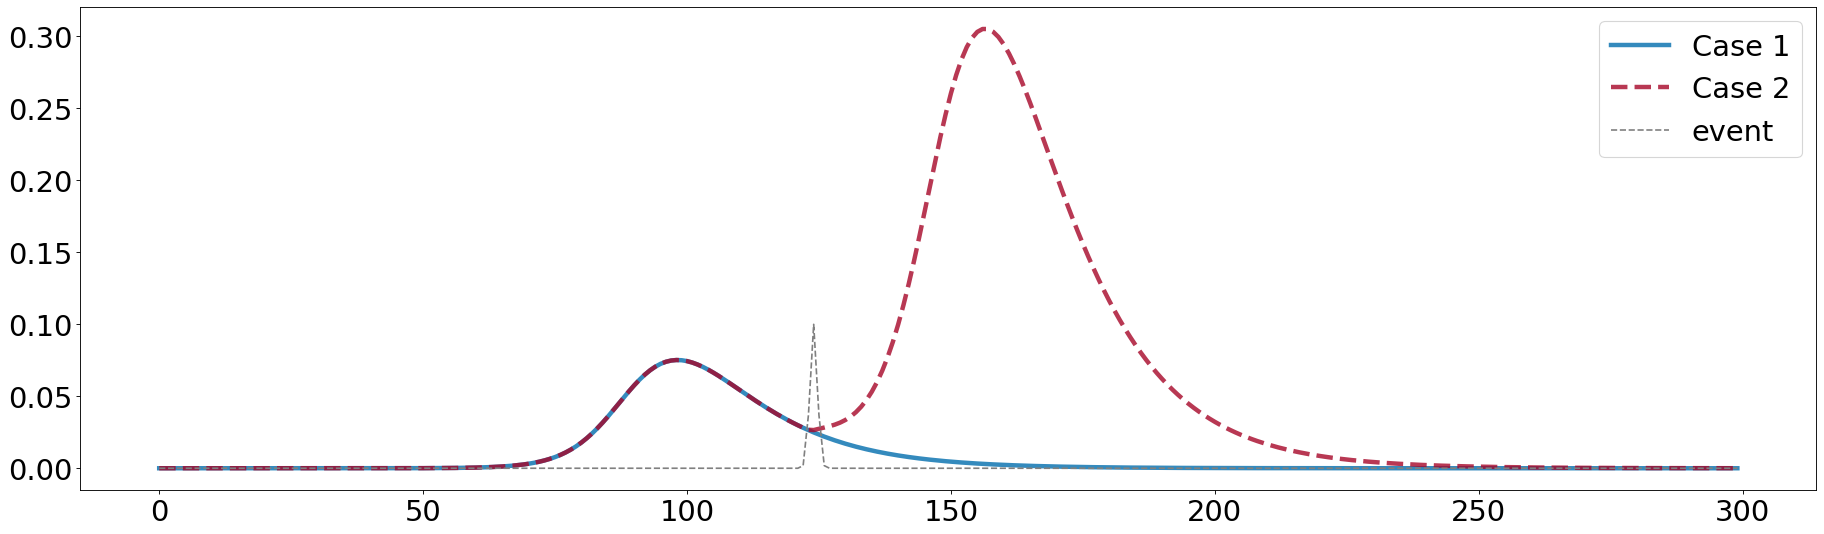

In [4]:
fig = plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.sum(Is1, axis=1)/N, '-', lw=4, color='#348ABD', label='Case 1', alpha=1); 
plt.plot(np.sum(Is2, axis=1)/N, '--', lw=4, color='#A60628', label='Case 2', alpha=0.8); 

plt.plot(0.1*np.exp(-(np.arange(300)-124)**2), '--', color='gray', label='event'); plt.legend();